In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

In [2]:
from DFTStructureGenerator import DFThandle
import os, glob
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import pickle
from matplotlib import pyplot as plt
np.random.seed(0)

In [9]:
binol_3_3 = [ 2,  3,  4,  5,  6, 26, 27, 39, 35, 31, 42, 41, 40, 34, 32, 30, 28, 29, 44, 33, 37, 43, 36, 38]
binol_4_4 = [7, 8, 9]
binol_6_6 = [10, 11, 12, 13, 14, 15, 16, 17]
binol_7_7 = [18, 19, 20, 21, 22]
binol_other = [ 1, 23, 25, 24]
all_binol_split = [binol_3_3, binol_4_4, binol_6_6, binol_7_7, binol_other]

In [11]:
data_dir = "Data"
csv_dir = os.path.join(data_dir, "Iteration_2", "Result")
row_csv = "Data_clear.csv"
target_csv = "Data_clear_with_sites.csv"

In [69]:
with open(r"Data/DFT/all_fp_map2.pkl", 'rb')as f:
    qm_dict, area_dict = pickle.load(f)

# 1. Full Reaction Space Conclusion

In [12]:
smiles_csv = pd.read_csv(target_csv)
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
ligand_csv = smiles_csv.loc[(smiles_csv['Type'] == 'Ligand_Box') | (smiles_csv['Type'] == 'Ligand_Other')]
# ligand_csv = ligand_csv.loc[np.isin(ligand_csv['Index'] - 1000, allowed_ligand)]

In [13]:
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
ligand_csv = smiles_csv.loc[(smiles_csv['Type'] == 'Ligand_Box') | (smiles_csv['Type'] == 'Ligand_Other')]
new_dict = {"Binol":{}, "Ligand":{}, "Binol_smiles":{},"Ligand_smiles":{}, "Binol_conf_id":{}, "Ligand_conf_id":{}, "Binol_Sites":{}, "Ligand_Sites":{}, "Binol_G":{}, "Ligand_G":{}}
new_dict_id = 0
for _, binol_row in binol_csv.iterrows():
    for _, ligand_row in ligand_csv.iterrows():
        new_dict["Binol"][new_dict_id] = binol_row['Index']
        new_dict["Ligand"][new_dict_id] = ligand_row['Index']
        new_dict["Binol_smiles"][new_dict_id] = binol_row['Smiles']
        new_dict["Ligand_smiles"][new_dict_id] = ligand_row['Smiles']
        new_dict["Binol_conf_id"][new_dict_id] = binol_row['conf_id']
        new_dict["Ligand_conf_id"][new_dict_id] = ligand_row['conf_id']
        new_dict["Binol_Sites"][new_dict_id] = binol_row['Sites']
        new_dict["Ligand_Sites"][new_dict_id] = ligand_row['Sites']
        new_dict["Binol_G"][new_dict_id] = binol_row['G/Hatree']
        new_dict["Ligand_G"][new_dict_id] = ligand_row['G/Hatree']
        new_dict_id += 1
new_dict = pd.DataFrame(new_dict)
new_dict.to_csv("Data/Iteration_2/Full_Space_20251106.csv", index=False)

# 2. Active Learning

In [ ]:
full_data_csv = DFThandle.read_reaction_csv("Data/Iteration2/Full_Space_ActiveLearning.csv")
data_clear_csv = pd.read_csv("Data_clear_with_sites.csv")
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(row['Smiles']), 2, nBits=2048) for row_id, row in data_clear_csv.iterrows()]
mfps = np.array(fps) @ np.array(fps).T
row_id_idx = {row["Index"]: row_id for row_id, row in data_clear_csv.iterrows()}
target_idx = [[row_id_idx[row["Binol"]], row_id_idx[row["Ligand"]]] for row_id, row in full_data_csv.iterrows()]

## Init Round

In [ ]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import DataStructs
def distij(i,j):
    return 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])
    
def distanceij(i,j):
    B_i, L_i = target_idx[i]
    B_j, L_j = target_idx[j]
    return distij(B_i, B_j) + distij(L_i, L_j)#  * rate_a # + var_j * rate_b
Times = 0      
picker = MaxMinPicker()
first_picker_idx = picker.LazyPick(distanceij, len(full_data_csv), 50, firstPicks=[2994])
np.save(f'Data/Iteration_Data2/iter_{Times:05}.npy', first_picker_idx)
full_data_csv.iloc[first_picker_idx].to_csv(f"Data/Iteration_Data2/iter_{Times:05}_sameBinol.csv", index=False)

## Next Round(1-5)

In [ ]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import DataStructs

def distij(i,j):
    return 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])

def generate_similarity(B_i, L_i, B_j, L_j):
    k = mfps[B_i, B_j] + mfps[L_i, L_j]
    return k / (mfps[B_i, B_i] + mfps[L_i, L_i] + mfps[B_j, B_j] + mfps[L_j, L_j] - k)

def distanceij(i,j):
    B_i, L_i = target_idx[i]
    B_j, L_j = target_idx[j]
    var_i = this_uncertainty[i]
    return distij(B_i, B_j) + distij(L_i, L_j) + var_i + avaliable(B_i, L_i) * 1000

def get_uncertainty(first_data_csv):
    train_X = DFThandle.descriptor_to_array(first_data_csv, None, [qm_dict, area_dict])
    train_Y = first_data_csv['R'].to_numpy() - first_data_csv["S"].to_numpy()
    temp_train_X =  DFThandle.get_reverse_result(train_X)
    temp_train_Y = train_Y * -1
    train_X = np.concatenate([train_X, temp_train_X])
    train_Y = np.append(train_Y, temp_train_Y)
    
    model = CatBoostRegressor(task_type="CPU", iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0, loss_function='RMSEWithUncertainty')
    model.fit(train_X, train_Y)
    new_desc_array = DFThandle.descriptor_to_array(full_data_csv, None, [qm_dict, area_dict])
    new_result, new_uncertainty = model.predict(new_desc_array).T
    return new_result, new_uncertainty

In [ ]:
Times = 5
first_data_csv = DFThandle.read_reaction_csv(f"Data/Iteration_2/Result/BINOL_result_sum_{Times-1:04}.csv")
first_idxs = np.load(f"Data/Iteration_2/Iteration_Data/iter_{Times-1:05}.npy")
all_result, this_uncertainty = get_uncertainty(first_data_csv)
full_data_csv['Pred_Value'] = all_result
pre_select_id = first_idxs.tolist()
picker = MaxMinPicker()
picker_idx = picker.LazyPick(distanceij, len(full_data_csv), len(first_idxs) + 50, firstPicks=pre_select_id)
np.save(f'Data/Iteration_2/Iteration_Data/iter_{Times:05}.npy', picker_idx)
full_data_csv.iloc[picker_idx[-50:]].to_csv(f"Data/Iteration_2/Iteration_Data/iter_{Times:05}.csv", index=False)

## Next Round (6 - )

In [ ]:
data_csv = first_data_csv
y = data_csv['R'].to_numpy() - data_csv["S"].to_numpy()
all_X = DFThandle.descriptor_to_array(data_csv, None, [qm_dict, area_dict])
target = y
all_pred = np.zeros(len(all_X))
kf = KFold(n_splits=5, shuffle=True, random_state=1)
kf = list(kf.split(all_X))
r2_split = []
for train_ids, test_ids in kf:
    model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
    train_X, train_Y = all_X[train_ids], target[train_ids]
    temp_train_X =  DFThandle.get_reverse_result(train_X)
    temp_train_Y = train_Y * -1
    train_X_ = np.concatenate([train_X, temp_train_X])
    train_Y_ = np.append(train_Y, temp_train_Y)
    model.fit(train_X_, train_Y_)
    y_pred = model.predict(all_X[test_ids])
    all_pred[test_ids] = y_pred
for binol_split_id, binol_split in enumerate(all_binol_split):
    row_in_split = [id_ for id_, each in data_csv.iterrows() if each['Binol'] in binol_split]
    r2_split.append(r2_score(target[row_in_split], all_pred[row_in_split]))

In [ ]:
import numpy as np

def stratified_sample_allocation(n, weights):
    weights = np.array(weights)
    expected = n * weights
    floors = np.floor(expected).astype(int)
    fractions = expected - floors
    remaining = n - np.sum(floors)

    sorted_indices = np.argsort(-fractions)
    
    allocations = floors.copy()
    allocations[sorted_indices[:remaining]] += 1
    return allocations

weight = (1 - np.array(r2_split)) * np.array([len(each) for each in all_binol_split])
weight /= np.sum(weight)
binol_sample_num = stratified_sample_allocation(50, weight)
binol_sample_num

In [ ]:
def avaliable(B_j, L_j):
    if B_j in binol:
        return 1.0
    else:
        return 0.0

In [ ]:
Times = 15
first_idxs = np.load(f"Data/Iteration_2/Iteration_Data/iter_{Times-1:05}.npy")
picker_idx = first_idxs.tolist()
for binol, binol_sample in zip(all_binol_split, binol_sample_num.tolist()):
    if binol_sample <= 0:
        continue
    picker = MaxMinPicker()
    picker_idx = picker.LazyPick(distanceij, len(full_data_csv), len(picker_idx) + binol_sample, firstPicks=list(picker_idx))
full_data_csv['Pred_Value'] = all_result
np.save(f'Data/Iteration_2/Iteration_Data/iter_{Times:05}.npy', picker_idx)
full_data_csv.iloc[list(picker_idx)[-np.sum(binol_sample_num):]].to_csv(f"Data/Iteration_2/Iteration_Data/iter_{Times:05}.csv", index=False)

## Summariz Data

In [6]:
csvs = glob.glob("Data/Iteration_2/Result/BINOL_result_0*.csv")
for id_, _ in enumerate(csvs):
    target_df = pd.DataFrame()
    for csv in csvs[:id_ + 1]:
        temp_df = pd.read_csv(csv).dropna()
        target_df = pd.concat([target_df, temp_df])
    target_df.to_csv(f"Data/Iteration_2/Result/BINOL_result_sum_{id_:04}.csv", index=False)
    

# Final Recommendation

In [71]:

smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
important_binol_id = np.arange(max(binol_csv['Index'].to_list())+1)
# important_binol_id = [24, 62, 805]
full_data_csv = pd.read_csv('Data/Iteration_2/Full_Space_20251106.csv')
for id_ in range(14,15):
    first_data_csv = DFThandle.read_reaction_csv(rf'Data\Iteration_2\Result\BINOL_result_sum_{id_:04}.csv')
    old_desc_array = DFThandle.descriptor_to_array(first_data_csv, None, [qm_dict, area_dict])
    old_y = first_data_csv['R'].to_numpy() - first_data_csv["S"].to_numpy()
    model = CatBoostRegressor(task_type="CPU", iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
    model.fit(old_desc_array, old_y)
    new_desc_array = DFThandle.descriptor_to_array(full_data_csv, None, [qm_dict, area_dict])
    new_y = model.predict(new_desc_array).T
    full_data_csv['PredER'] = new_y
    target_ids = []
    for binol_id in important_binol_id:
    # for binol_id in [63]:
        temp_csv = full_data_csv.loc[full_data_csv['Binol'] == binol_id]
        already_ligand = first_data_csv.loc[first_data_csv['Binol'] == binol_id]['Ligand'].to_list()
        # temp_csv = full_data_csv.loc[full_data_csv['In Dataset'] == 0]
        temp_csv['PredERAbs'] = np.abs(temp_csv['PredER'])
        temp_csv = temp_csv.sort_values(by='PredERAbs', ascending=False)
        temp_csv = temp_csv.loc[~np.isin(temp_csv["Ligand"], already_ligand)]
        target_ids +=[row_id for row_id, row in temp_csv.iterrows()][:10]
        # temp_csv = temp_csv.sort_values(by='PredER', ascending=True)
        # target_ids += [row_id for row_id, row in temp_csv.iterrows()][:3]
    # target_ids = list(set(target_ids))
    new_csv = full_data_csv.iloc[target_ids]
    new_csv['PredE'] = (new_csv['PredER'] + 100) / 2
    new_csv['PredR'] = (new_csv['PredER'] - 100) / 2
    new_csv.to_csv(f"Data/Recommended/Pred_Important_Binol_11_06_{id_:04}.csv", index=False)

In [ ]:
# Full Space Prediction
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
important_binol_id = np.arange(max(binol_csv['Index'].to_list())+1)
full_data_csv = pd.read_csv('Data/Iteration_2/Full_Space_20251029.csv')
first_data_csv = DFThandle.read_reaction_csv(rf'Data\Iteration_2\Result\BINOL_result_sum_{14:04}.csv')
old_desc_array = DFThandle.descriptor_to_array(first_data_csv, None, [qm_dict, area_dict])
old_y = first_data_csv['R'].to_numpy() - first_data_csv["S"].to_numpy()
model = CatBoostRegressor(task_type="CPU", iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
model.fit(old_desc_array, old_y)
new_desc_array = DFThandle.descriptor_to_array(full_data_csv, None, [qm_dict, area_dict])
new_y = model.predict(new_desc_array).T
full_data_csv['PredER'] = new_y
full_data_csv['PredE'] = (full_data_csv['PredER'] + 100) / 2
full_data_csv['PredR'] = (full_data_csv['PredER'] - 100) / 2
full_data_csv.to_csv(f"Data/Recommended/Full_Space_Prediction_10_29_{14:04}.csv", index=False)

# Draw Active Learning Distribution

In [ ]:
plt.scatter(xbs[transfer_subset_indices[:cut_off_id]], xcs[transfer_subset_indices[:cut_off_id]], marker=".", c='green', s=5)

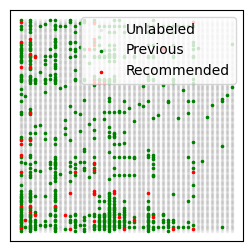

In [59]:
time = 14
old_df = pd.read_csv(f'Data/Iteration_2/Result/BINOL_result_sum_{time - 1:04}.csv')
new_df = pd.read_csv(f'Data/Iteration_2/Result/BINOL_result_{time + 1:04}.csv')
full_df = pd.read_csv("Data/Full_Space_pred.csv")
plt.figure(figsize=(3,3))
Binol_translation = {binol_id:id_ for id_, binol_id in enumerate(sorted(full_df['Binol'].unique().tolist()))}
Ligand_translation = {ligand_id:id_ for id_, ligand_id in enumerate(sorted(full_df['Ligand'].unique().tolist()))}
plt.scatter([Binol_translation[each] for each in full_df['Binol']], [Ligand_translation[each] for each in full_df['Ligand']], marker=".", c='gray', s=10, label='Unlabeled', alpha=0.1)
                      
plt.scatter([Binol_translation[each] for each in old_df['Binol']], [Ligand_translation[each] for each in old_df['Ligand']], marker=".", c='green', s=10, label='Previous')

plt.scatter([Binol_translation[each] for each in new_df['Binol']], [Ligand_translation[each] for each in new_df['Ligand']], marker=".", c='red', s=10, label='Recommended')

plt.xticks([])
plt.yticks([])
plt.legend(loc='upper right')
plt.savefig(f"Figure/Active_Learning_Distribution_{time:04}_3.png", dpi=300, bbox_inches='tight')

In [13]:
# Top Rank
all_rank = []
experimental_csv = pd.read_csv('BINOL_result_Fig4.csv')
# predict_csv = pd.read_csv(r'Data\Recommended\Pred_Important_Binol_10_29_0014.csv')
predict_csv = pd.read_csv(r'Data\Recommended\Pred_Important_Binol_11_06_0014.csv')
for row_id, row in experimental_csv.iterrows():
    binol, ligand = row['Binol'], row['Ligand']
    temp_predict = predict_csv.loc[(predict_csv['Binol'] == binol)]
    try:
        rank = temp_predict['Ligand'].tolist().index(ligand) + 1
    except:
        continue
    all_rank.append(rank)

In [51]:
temp_row

BINOL           3.0
Rec. Ligand    1019
Pred. er       2:98
Expt. er       2:98
Name: 0, dtype: object

In [28]:
df = pd.read_excel('Validation_Result.xlsx')
new_num_df = pd.read_excel('New_number.xlsx')
translation_dict = {old: new for new, old in zip(new_num_df['New'], new_num_df['Old'])}
all_rank_train = []
all_rank_test = []
temp_id = []
for row_id, row in df.iterrows():
    temp_id.append(row_id)
    if row_id == len(df) - 1 or not np.isnan(df.iloc[row_id + 1]['BINOL']):
        temp_df = df.iloc[temp_id].reset_index(drop=True)
        pred_value, exp_value = [], []
        for id_, temp_row in temp_df.iterrows():
            pred_r, pred_s = [int(each) for each in temp_row['Preder'].split(":")]
            exp_r, exp_s = [int(each) for each in temp_row['Expter'].split(":")]
            pred_value.append(np.abs(pred_r - pred_s))
            exp_value.append(np.abs(exp_r - exp_s))
        best_exp_id = np.argmax(exp_value)
        best_pred_value = pred_value[best_exp_id]
        pred_value.sort(reverse=True)
        rank = pred_value.index(best_pred_value) + 1
        if translation_dict[temp_df['BINOL'][0]] <= 44:
            all_rank_train.append(rank)
        else:
            all_rank_test.append(rank)
        temp_id = []


In [29]:
# 计算覆盖率
for all_rank in [all_rank_train, all_rank_test]:
    cover_rate = [np.sum(np.array(all_rank) <= each) / len(all_rank) for each in range(1, np.max(all_rank) + 1)]
    print(cover_rate)

[0.5, 0.5555555555555556, 0.7222222222222222, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 1.0]
[0.23809523809523808, 0.47619047619047616, 0.6190476190476191, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 1.0]


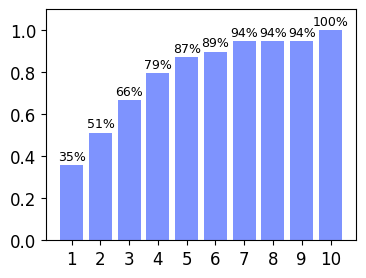

In [19]:
plt.figure(figsize=(4,3))
plt.xticks(range(1, np.max(all_rank) + 1), fontsize=12)
plt.yticks(fontsize=12)
bars = plt.bar(range(1, 11), cover_rate, color='#7e93fe')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{int(yval * 100):2d}%', ha='center', va='bottom', fontsize=9)
# plt.xlabel('Top Rank', fontsize=12)
plt.ylim(0, 1.1)
plt.savefig('Figure/cover_rate.png', dpi=300, bbox_inches='tight')

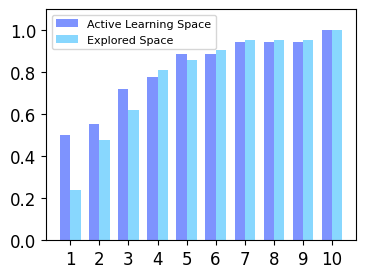

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 all_rank_train 和 all_rank_test 已定义为列表或数组
# 计算 train 和 test 的覆盖率
max_rank_display = 10  # 显示前 10 个 rank
cover_rate_train = [np.mean(np.array(all_rank_train) <= k) for k in range(1, max_rank_display + 1)]
cover_rate_test = [np.mean(np.array(all_rank_test) <= k) for k in range(1, max_rank_display + 1)]

plt.figure(figsize=(4, 3))
x = np.arange(1, max_rank_display + 1)
width = 0.35

# 绘制 train 柱子
bars_train = plt.bar(x - width / 2, cover_rate_train, width, label='Active Learning Space', color='#7e93fe')
# 绘制 test 柱子
bars_test = plt.bar(x + width / 2, cover_rate_test, width, label='Explored Space', color='#88d7fe')

# # 为 train 柱子添加标签
# for bar in bars_train:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{int(yval * 100):2d}%', 
#              ha='center', va='bottom', fontsize=9)

# # 为 test 柱子添加标签
# for bar in bars_test:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{int(yval * 100):2d}%', 
#              ha='center', va='bottom', fontsize=9)

plt.xticks(x, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=8)
plt.ylim(0, 1.1)
plt.savefig('Figure/cover_rate.png', dpi=300, bbox_inches='tight')
# plt.close()  # 关闭图形以释放内存